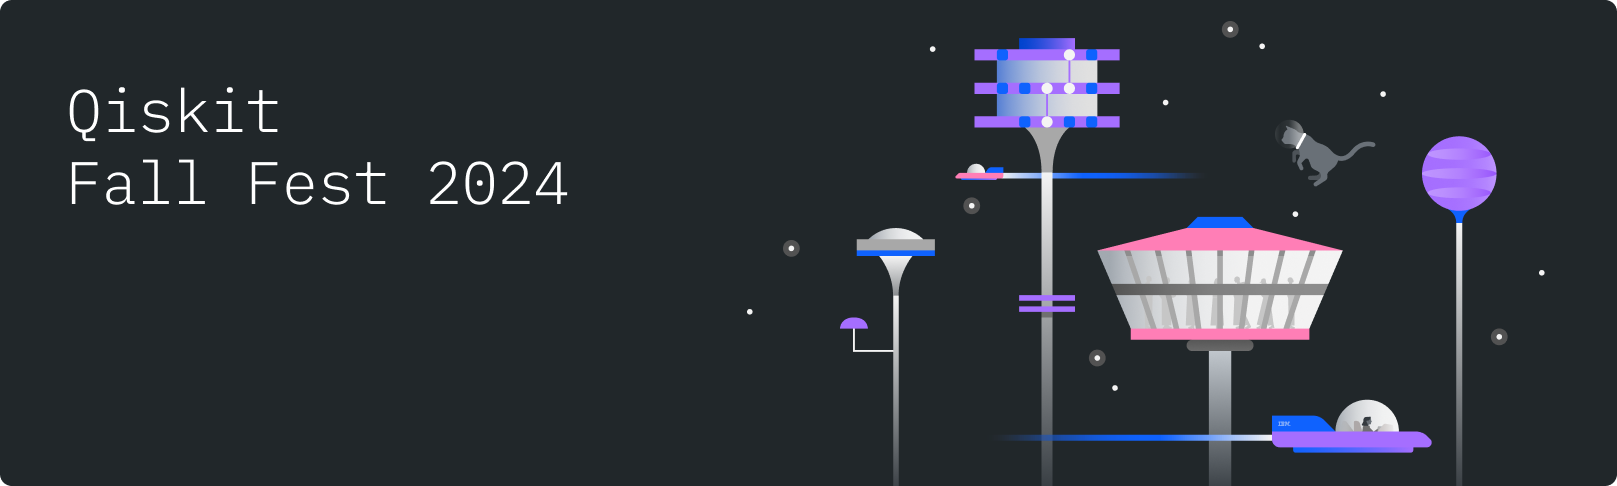

# Challenge 3: The transpiler

## Part 0: Set up and Import the required packages

In [1]:
# If you use Colab, uncomment below line and run this cell
# %pip install git+https://github.com/goseumdochy/qiskit-fall-fest-2024ku-challenge-grader.git

In [13]:
### Import the required packages
import matplotlib.pyplot as plt

from qiskit.circuit.random import random_circuit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

### IBM Quantum API token 을 저장하기

1. [IBM Quantum Platform](https://quantum.ibm.com/) 에 접속하여 로그인 하기
2. 우측 상단의 API token 복사하기 버튼 클릭하기(위의 그림 참고)
3. 아래의 코드셀에서 `Your_token_here` 부분을 여러분의 API token으로 대체하기
4. 여러분의 API token은 쌍따옴표 안에 있어야합니다!!

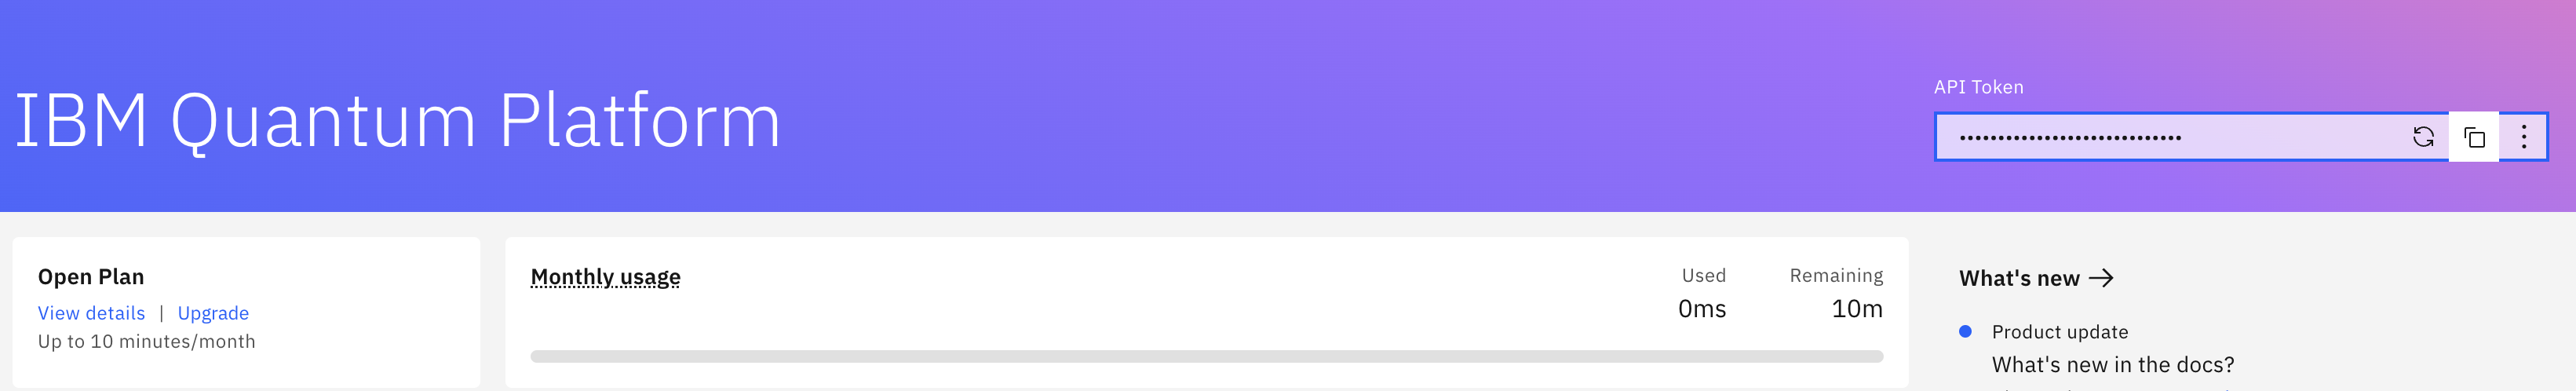

In [2]:
## Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(

    channel="ibm_quantum",

    token="Your_token_here",

    set_as_default=True,

    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

# Load saved credentials
service = QiskitRuntimeService()

### 정보 기입하기

기입해준 정보를 바탕으로 서버에 참가자 식별이 되오니, 특히 학번(student_id)은 정확하게 기입해주시길 바랍니다!

In [12]:
event = "2024 Qiskit Fall Fest at Korea University"

## Write your code below here. Delete the current information and replace it with your own ##
## Make sure to write your information between the quotation marks!

username = "test"

major = "Electrical Engineering"

student_id = "202017xxxx"

## Now press the "Run" button in the toolbar above, or press Shift + Enter while you're active in this cell

## Part 1: Prologue - What is the transpiler?

가상의 질문으로 시작해봅시다:

친구가 당신에게 차 열쇠를 건네며 "내 차에 연료를 채워 줄 수 있겠니?"라고 한다면, 당신은 무엇을 해야 할지 어떻게 알까요?

물론 당신은 운전면허증은 가지고 있다고 합시다. 친구가 어떤 차를 가지고 있는지 어떻게 알죠? 기어 변속기는 어디에 있고, 방향을 틀 때 깜빡이는 어떻게 켜나요? 연료 탱크를 여는 방법은? 만약 그 차가 연료 탱크가 없는 전기차라면 어떻게 하죠??

다행히도, 인간의 뇌는 똑똑합니다. 주어진 지시를 받아들이고, 차량을 파악하여 주어진 지시를 차량에 맞게 이행할 수 있죠.

이것이 바로 Qiskit에서 **트랜스파일러(transpiler)**의 본질입니다.

Transpilation은 주어진 입력 (논리적) 양자 회로를 특정 양자 장치에 맞는 동등한 회로로 다시 작성하거나, 실제 양자 시스템에서 실행하기 위해 회로를 최적화하는 과정입니다.

이 과정이 필요한 이유는 모든 양자 장치가 동일한 방식으로 작동하지 않기 때문입니다. 한 장치에 보낸 지시가 다른 양자 백엔드에서는 호환되지 않을 수 있습니다. Transpilation은 장치의 basis 게이트 집합, 양자 칩의 위상적 구조, 타이밍 제약 등을 기준으로 작동하며, 이를 이번 노트북에서 탐구할 예정입니다.

Transpiler의 목표는 노이즈가 있는 양자 하드웨어에서 최상의 성능을 얻는 것입니다. 대부분의 회로는 특정 타겟 장치와 호환되도록 변환을 거쳐야 하며, 결과에 영향을 미치는 노이즈를 줄이기 위해 최적화되어야 합니다.

예시를 들자면 아래와 같은 회로가 transpiler를 거치면

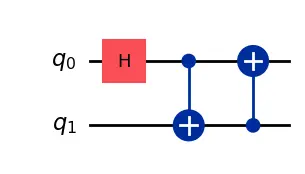

아래와 같은 회로가 될 수 있습니다.

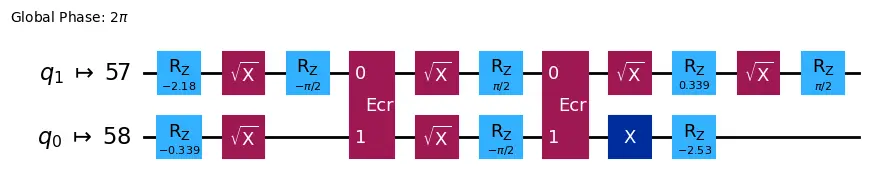

그리고 트랜스파일러는 해당 양자 컴퓨터가 수용할 수 있는 **basis 게이트**나 명령만을 사용하여, 원래 원하던 회로로 변환합니다. 또한, 노이즈의 영향을 최소화하기 위해 이러한 명령을 최적화합니다. 

이 과정은 주어진 양자 장치의 특성에 맞게 회로를 조정하여 최적의 성능을 끌어낼 수 있도록 돕는 핵심적인 과정입니다.

### Basis 게이트란 무엇일까?

양자컴퓨터의 basis 게이트란 무엇일까요? 하나의 비트에 0과 1상태만 존재하는 고전컴퓨터와는 다르게 양자컴퓨터는 복소수 amplitude 개념이 존재합니다. 하나의 큐비트만 생각하더라도 가질 수 있는 양자 상태는 무수히 많습니다. 이러한 무수히 많은 변환에 대한 모든 연산 기능을 양자컴퓨터에 담는 것은 불가능 합니다. 그래서 양자컴퓨터는 특정 수학적 구조를 만족하는 basis 게이트 집합을 직접적으로 구현할 수 있도록 설계되어 있습니다.

그 보다 더 복잡한 연산은 그러한 basis 게이트들의 조합으로 구현을 하는 것입니다. 이것과 관련 있는 개념으로는 [Universal quantum gates](https://en.wikipedia.org/wiki/Quantum_logic_gate#Universal_quantum_gates)와 [Solovay-Kitaev theorem](https://en.wikipedia.org/wiki/Solovay%E2%80%93Kitaev_theorem)이 있습니다. Challenge가 종료된 이후, 관심 있으신 분은 링크를 통해 내용을 보시면 좋을 것 같습니다. 특히 group theory, 그 중에서도 Lie group 개념에 대해 잘 아시는 분은 Solovay-Kitaev theorem 관련 내용을 한 번 보시는 것을 추천드립니다.

아래의 코드셀에서는 IBM의 양자컴퓨터 중 하나인 ibm_brisbane의 basis 게이트를 볼 수 있는 코드가 담겨 있습니다.

In [32]:
# Basis gates of ibm_brisbane machine.

# Select a backend
backend = service.backend('ibm_brisbane')
# backend = service.least_busy(operational=True, simulator=False)

backend.configuration().basis_gates

NameError: name 'service' is not defined

Qiskit의 **transpiler**는 양자 회로의 깊이와 복잡성을 줄이기 위해 모듈화 및 확장성을 염두에 두고 설계된 Qiskit SDK의 핵심 구성 요소입니다. 이 transpiler의 주요 목표는 새로운 회로 변환(a.k.a. transpiler passes)을 작성하고 기존의 다른 패스와 결합하여 양자 회로를 최적화하는 것입니다. 어떤 패스가 함께 연결되고 어떤 순서로 실행되는지는 최종 결과에 큰 영향을 미칩니다. 이 파이프라인은 [PassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager)와 [StagedPassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.StagedPassManager) 객체에 의해 결정됩니다.

### PassManager와 StagedPassManager
- **StagedPassManager**는 하나 이상의 PassManager의 실행을 조율하고, 이들이 실행되는 순서를 결정합니다. 
- **PassManager** 객체는 하나 이상의 패스를 모아 놓은 컬렉션에 불과합니다. 

비유하자면, **StagedPassManager**는 오케스트라의 지휘자와 같고, **PassManagers**는 다양한 악기 섹션, 그리고 **Pass** 객체들은 개별 음악가에 해당합니다. 

이러한 방식으로 하드웨어 효율적인 양자 회로를 구성하여 유틸리티 규모의 작업을 수행하면서도 노이즈를 관리할 수 있습니다. 

더 많은 세부정보는 IBM Quantum Platform 문서의 [Transpile](https://docs.quantum.ibm.com/transpile) 섹션을 참조하세요.

### Transpilation의 6개의 단계와 미리 구축된 4가지 수준의 transpilation

하드웨어 제약 조건에 맞게 양자 회로를 다시 작성하고 성능을 최적화하는 것이 쉽지만은 않습니다. Qiskit은 사용자에게 미리 구축된 4개의 트랜스파일 파이프라인과 함께 표준 6단계의 컴파일 흐름을 제공합니다. 기본적으로 사전 설정된 패스 매니저는 6단계로 구성되며 각 단계마다 여러 옵션이 있습니다:

1. **Init**: 이 단계는 시스템에 맞게 회로를 재설정하기 전에 필요한 모든 초기 패스를 실행하는 단계입니다. 일반적으로 사용자 정의 명령을 분해하여 회로를 단일 및 2-큐비트 게이트로 전환하는 것을 포함합니다. (회로의 게이트와 연산을 검증하고 다중 큐비트 게이트를 단일 및 2-큐비트 게이트로 변환합니다.)
2. **Layout**: 이 단계에서는 회로의 가상 큐비트를 실제 양자 하드웨어의 물리적 큐비트에 매핑하는 레이아웃을 적용합니다.
3. **Routing**: 이 단계는 레이아웃이 적용된 후에 실행되며, 원래 회로에 SWAP 게이트를 추가하여 백엔드의 연결성과 호환되도록 합니다.
4. **Translation**: 이 단계에서는 회로의 게이트를 대상 백엔드의 basis 게이트 집합으로 변환합니다.
5. **Optimization**: 이 단계는 조건(예: 지정된 회로의 깊이(길이))이 충족될 때까지 주요 최적화 루프를 반복 실행합니다.
6. **Scheduling**: 이 단계는 실제 양자 하드웨어에서 실행되는 일련의 신호들의 스케줄을 조정하는 패스들로 구성되어 있습니다.

이러한 6가지 단계를 하나하나 따져가며 사용자가 자신의 회로와 양자 하드웨어에 맞게 조절하면 분명 좋은 결과를 얻을 수 있을 것입니다. 하지만 이를 다 파악하고 사용하기 어려운 사용자들을 위해 Qiskit 에서는 이 6가지 단계의 수준을 잘 조합하여 누구나 쉽게 가져다가 사용할 수 있는 4가지의 미리 정의된 transpilation 수준도 제공합니다. 따라서 양자 회로 최적화에 익숙하지 않은 사용자에게는 이러한 준비된 4개의 루틴 중 하나를 사용하는 것이 좋습니다.

### Exercise 1:

<div class="alert alert-block alert-success">

**해야할 일:** 아래의 코드 셀에서 다음은 각 단계에서 발생하는 내용을 해당하는 transpilation 단계 이름과 연결지으세요.

- **A.** 이 단계는 여러 최적화 옵션을 사용하여 회로 작업 수와 회로의 깊이를 줄이는 데 중점을 둡니다.
- **B.** 이 단계는 선택된 레이아웃과 양자 하드웨어의 연결성을 고려하여 회로를 실행하기 위해 적절한 수의 SWAP 게이트를 삽입합니다.
- **C.** 이 단계는 두 개 이상의 큐비트에서 작동하는 복잡한 게이트를 하나 또는 두 개의 큐비트에서만 작동하는 게이트로 변환하는 데 사용됩니다.
- **D.** 이 단계는 실제 양자 장치에서 "가상" 큐비트를 "물리적" 큐비트에 1:1 매핑하여 일련의 게이트를 실행합니다.
- **E.** 이 단계는 게이트 실행 사이의 대기 시간을 고려하여 지연 명령과 같은 하드웨어 인식 작업을 명시적으로 삽입합니다.
- **F.** 이 단계는 회로에 지정된 게이트를 지정된 백엔드의 basis 게이트로 변환합니다.

<b>힌트: </b> 답변은 항상 큰따옴표로 묶인 한 개의 대문자입니다. 예시: "A"

</div>

In [14]:
answer1 = {}

# Place the correct letter next to the corresponding stage, inside a parenthesis
# example:  ans["test"] = "M"

answer1["init"] = "C"
answer1["layout"] = "D"
answer1["routing"] = "B"
answer1["translation"] = "F"
answer1["optimization"] = "A"
answer1["scheduling"] = "E"

In [15]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge3a

grade_challenge3a(answer1, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


잘 이해하고 계시네요! 이제 Qiskit의 trasnpilatioon 여섯 단계를 `preset_pass_manager`를 사용하여 어떻게 활용하는지 알아보겠습니다.

## Part 2: Transpile with preset pass managers

이 부분에서는 Qiskit의 표준 여섯 가지 transpilation 단계를 사용하는 방법을 살펴보겠습니다. 먼저 네 가지 미리 정의된 transpile pipeline에 초점을 맞추고, 각 패스를 사용하는 기능과 옵션을 활용하여 나만의 PassManager를 만드는 방법에 대해 알아보겠습니다.

먼저, Passmanager와 `generate_preset_pass_manager`가 무엇인지 살펴보겠습니다. 이 부분과 이후 부분에서는 transpiler와 관련된 [IBM Quantum Platform docs](https://docs.quantum.ibm.com/transpile)와 [API reference documentation](https://docs.quantum.ibm.com/api/qiskit/transpiler)를 자주 참조하므로, 함께 살펴보면서 문제를 푸는 것을 추천합니다.

### What is a (staged) pass manager?

Pass manager는 transpiler 패스 목록을 저장하고 이를 회로에 실행할 수 있는 객체입니다. Transpiler 패스의 목록으로 [PassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager)를 초기화하여 패스 매니저를 생성할 수 있습니다. 회로에 대해 transpilation을 행하려면 회로를 입력으로 하여 [run](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager#run) 메서드를 호출하면 됩니다.

[`StagedPassManager`](https://docs.quantum.ibm.com/transpile/transpiler-stages) 클래스에 의해 나타나는 staged pass manager는 일반 패스 매니저의 추상화 레벨 위에 있는 특별한 종류의 패스 매니저입니다. 일반 pass manager는 여러 transpiler passes로 구성되지만, staged pass manager는 여러 pass managers로 구성됩니다. 이는 전송이 일반적으로 분리된 단계로 이루어지며, 각 단계가 패스 매니저로 나타나기 때문에 유용한 추상화입니다.

### `Preset Passmanagers`

Preset Passmanagers(`qiskit.transpiler.preset_passmanagers`)는 transpilation을 위한 preset pass manager를 생성하는 기능을 포함하고 있습니다. Preset pass manager는 StagedPassManager의 인스턴스로, 미리 정의된 transpiling pipeline의 다양한 최적화 수준에서 회로 변환을 실행하는 데 사용됩니다. 여기서는 `generate_preset_pass_manager`를 사용하여 전체 pass manager를 생성하는 데 사용되는 함수들을 소개합니다.

### `generate_preset_pass_manager`

Qiskit에서 `generate_preset_pass_manager`는 미리 설정된 pass manager를 빠르게 생성하는 데 사용됩니다. 이 함수는 각 패스에 대한 **최적화** 수준과 옵션을 갖춘 독립형 `PassManager` 객체를 구성하는 편리하고 간단한 방법을 제공합니다. 이제 이러한 내용들을 살펴보겠습니다.

## Optimization levels

`generate_preset_pass_manager` 함수는 반드시 optimization_level 값을 입력으로 요구하며, 이 값은 transpiler가 회로를 최적화할 때 얼마 만큼의 노력을 기울일지를 결정합니다. 이 옵션의 값은 0, 1, 2, 3 중 하나의 값을 가질 수 있습니다.

높은 optimization_level의 값은 더 긴 시간을 소요해 더 많은 최적화 과정이 적용된 회로를 만들어 내며, 반대로 낮은 레벨의 값은 적은 시간으로 적은 최적화 과정만을 적용해 회로를 transpilation 합니다.

<div class="alert alert-block alert-success">

### Utility function(Not Exercise problem)

Transpilation의 실제 목표가 양자 회로의 실제 실행 성능을 개선하는 것이기 때문에, transpiler를 통과하여 변환된 회로의 성능을 측정하는 함수를 밑에 제공해드립니다. 이 함수는 이 챌린지 노트북에서 사용하게 될 것 입니다.

**함수 설명:** 함수 `scoring`은 transpiled circuit, 그러니깐 *[final layout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.TranspileLayout#final_layout)*,을 입력으로 받아야 합니다. 그 후 함수는 회로의 점수를 반환해야 하며, 점수가 0에 가까울수록 더 좋습니다.

2-큐비트 게이트인 `cz` 게이트는 단일 큐비트 게이트인 `sx` 게이트와 `rz` 게이트보다 더 많은 오류를 일으키기 때문에 cz 게이트 개수에 따른 패널티가 더 크도록 설정이 되었습니다.

추가 참고사항:
* 이 챌린지 노트북에서는 양자 하드웨어로 전체적으로 `qiskit-ibm-runtime`의 `FakeTorino`를 사용하세요.
</div>

In [16]:
def scoring(qc, backend):
    gate_count = qc.count_ops()
    if "cz" not in gate_count:
        gate_count["cz"] = 0

    score = gate_count['cz'] * 10
    score += gate_count['sx'] * 1
    score += gate_count['rz'] * 1
    return score

이제 transpiled circuit의 성능을 측정하는 함수가 준비되었습니다. 다음 부분으로 넘어가기 전에, fake 양자 하드웨어에서 회로를 제대로 테스트하기 위해 필요한 모든 설정을 완료합시다.

즉, transpile 되기 전의 임의의 회로와 fake 양자 하드웨어가 필요합니다!

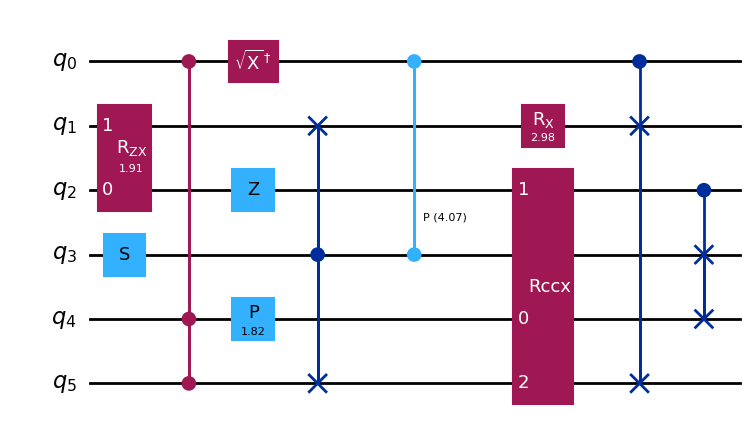

In [17]:
### Create a random circuit

## DO NOT CHANGE THE SEED NUMBER
seed = 10000

## Create circuit

num_qubits = 6
depth = 4
qc = random_circuit(num_qubits,depth,measure=False, seed=seed)

qc.draw('mpl')

<div class="alert alert-block alert-warning">

<b>주의하세요!</b>
    
채점을 위해서, 랩 전체 코드에서 `seed`나 `seed_transpiler`의 값을 변경하지 마세요.
</div>

각 최적화 레벨을 테스트하기 위해, 먼저 `FakeTorino`를 호출하여 `backend`로 지정합시다.

`FakeTorino`는 IBM Quantum의 가장 최신의 Heron 칩을 탑재한 ibm_torino의 연결 구조와 노이즈 특성을 가져옵니다.

In [18]:
## Save FakeTorino as backend
backend = FakeTorino()

## Check basis gate set of FakeTorino
backend.configuration().basis_gates

['cz', 'id', 'rz', 'sx', 'x']

네 개의 모든 최적화 레벨을 사용해 본 후 마지막에 결과들을 비교해 보게 될 것입니다. 그러기 위해서, 각 계산 결과를 저장하고 사용하기 위한 변수(딕셔너리 자료형)을 아래에 만들어 두었습니다.

다음의 코드 셀에 필요한 변수를 선언해 두었습니다. 수정할 필요 없이 실행시키고 그 다음으로 넘어가시면 됩니다.

In [19]:
circuit_depths = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}
gate_counts = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

scores = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

### Optimization level = 0

<div class="alert alert-block alert-info">

Optimization level에 대한 네 가지 섹션을 진행하면서 도움이 필요하거나 내용을 명확히 이해하기 어렵다면, optimization level에 대한 더 자세한 정보를 얻을 수 있는 <a href="https://docs.quantum.ibm.com/transpile/set-optimization">이 문서</a>를 확인해 주시길 바랍니다.

</div>

최적화 레벨 0은 **장비의 특성을 실험하기** 위한 것으로, 대상 양자 하드웨어의 제약에 맞게 입력 회로를 매핑하기는 하지만 최적화는 수행하지 않습니다. 이 단계에서는 [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout)을 사용하여 가상 큐비트와 동일한 물리적 큐비트를 선택하고 [StochasticSwap](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.StochasticSwap#stochasticswap)을 사용해 SWAP 게이트를 삽입하여 회로가 작동하도록 만듭니다.

Faketorino 양자 하드웨어를 사용하여 최적화 레벨 0으로 pass manager를 만들어보고 그 결과를 확인해 봅시다.

In [20]:
# Make a pass manager with our desired optimization level and backend
pm_lv0 = generate_preset_pass_manager(backend=backend, optimization_level=0, seed_transpiler=seed)

# Run for our random circuit
tr_lv0 = pm_lv0.run(qc)

# uncomment the next line to draw circuit
#tr_lv0.draw('mpl', idle_wires=False, fold=60)

앞서 언급했듯이, 최적화 레벨 0에서는 백엔드의 basis 게이트를 사용하여 기본적인 게이트 분해를 수행하며, 논리 큐비트를 물리 큐비트에 동일한 순서로 매핑합니다. 즉, 논리 큐비트 0은 실제 하드웨어의 큐비트 0번에 매핑되고, 논리 큐비트 1은 실제 하드웨어의 큐비트 1번에 매핑됩니다.

<div class="alert alert-block alert-success">

### Exercise 2: (Start)

**해야할 일:** 주어진 랜덤회로를 transpile 하여 회로의 깊이(circuit depth)와, 전체 게이트 수의 합, 그리고 회로의 성능을 'scoring' 함수를 사용하여 계산한 후 앞서 만들어둔 변수에 저장해주세요.

아래의 팁을 참고하시길 바랍니다.

</div>

<div class="alert alert-block alert-info">

팁:
- `circuit_depths`: [IBM Documentation](https://docs.quantum.ibm.com/api/qiskit/0.42/circuit)에서 회로의 깊이에 대한 정보를 확인할 수 있습니다.
- `gate_counts`: 우리는 종종 회로의 "크기"를 명령어의 총 개수로 나타냅니다. 이에 대한 정보는 [Size](https://docs.quantum.ibm.com/api/qiskit/0.42/qiskit.circuit.QuantumCircuit#size)에서 확인할 수 있습니다.
- `scores`: 이전에 작성한 `scoring` 함수를 사용하여 점수를 계산하세요.

</div>

In [21]:
### Your code here ###

circuit_depths['opt_lv_0'] = tr_lv0.depth()
gate_counts['opt_lv_0'] = tr_lv0.size()
scores['opt_lv_0'] = scoring(tr_lv0, backend)

### Don't change code after this line ###

print("Optimization level 0 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_0'])
print("Gate count:", gate_counts['opt_lv_0'])
print("Score:", scores['opt_lv_0'])

Optimization level 0 results
Circuit depth: 327
Gate count: 566
Score: 1547


### Optimization level = 1

최적화 레벨 1은 **가벼운 최적화**를 수행합니다. 그 의미는 다음과 같습니다:

- **Layout/Routing**: 레이아웃은 먼저 [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout)을 사용하여 시도됩니다. 추가적인 SWAP이 필요할 경우 [SabreSWAP](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.SabreSwap#sabreswap)을 사용하여 최소한의 SWAP을 포함한 레이아웃을 찾은 후, [VF2LayoutPostLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.VF2PostLayout)을 사용해 그래프에서 가장 적합한 큐비트를 선택하려고 합니다.
- [InverseCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.InverseCancellation#inversecancellation): 서로 상쇄되는 역 게이트들을 찾아 제거합니다.
- [1Q gate optimization](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Optimize1qGates#optimize1qgates): 1큐비트 게이트를 최적화합니다.

이번에는 `generate_preset_pass_manager`를 사용하여 직접 pass manager를 만들어보세요. FakeTorino 백엔드를 사용하고, `optimization_level`을 1로 설정하며, `seed_transpiler` = `seed`로 설정해 주세요.

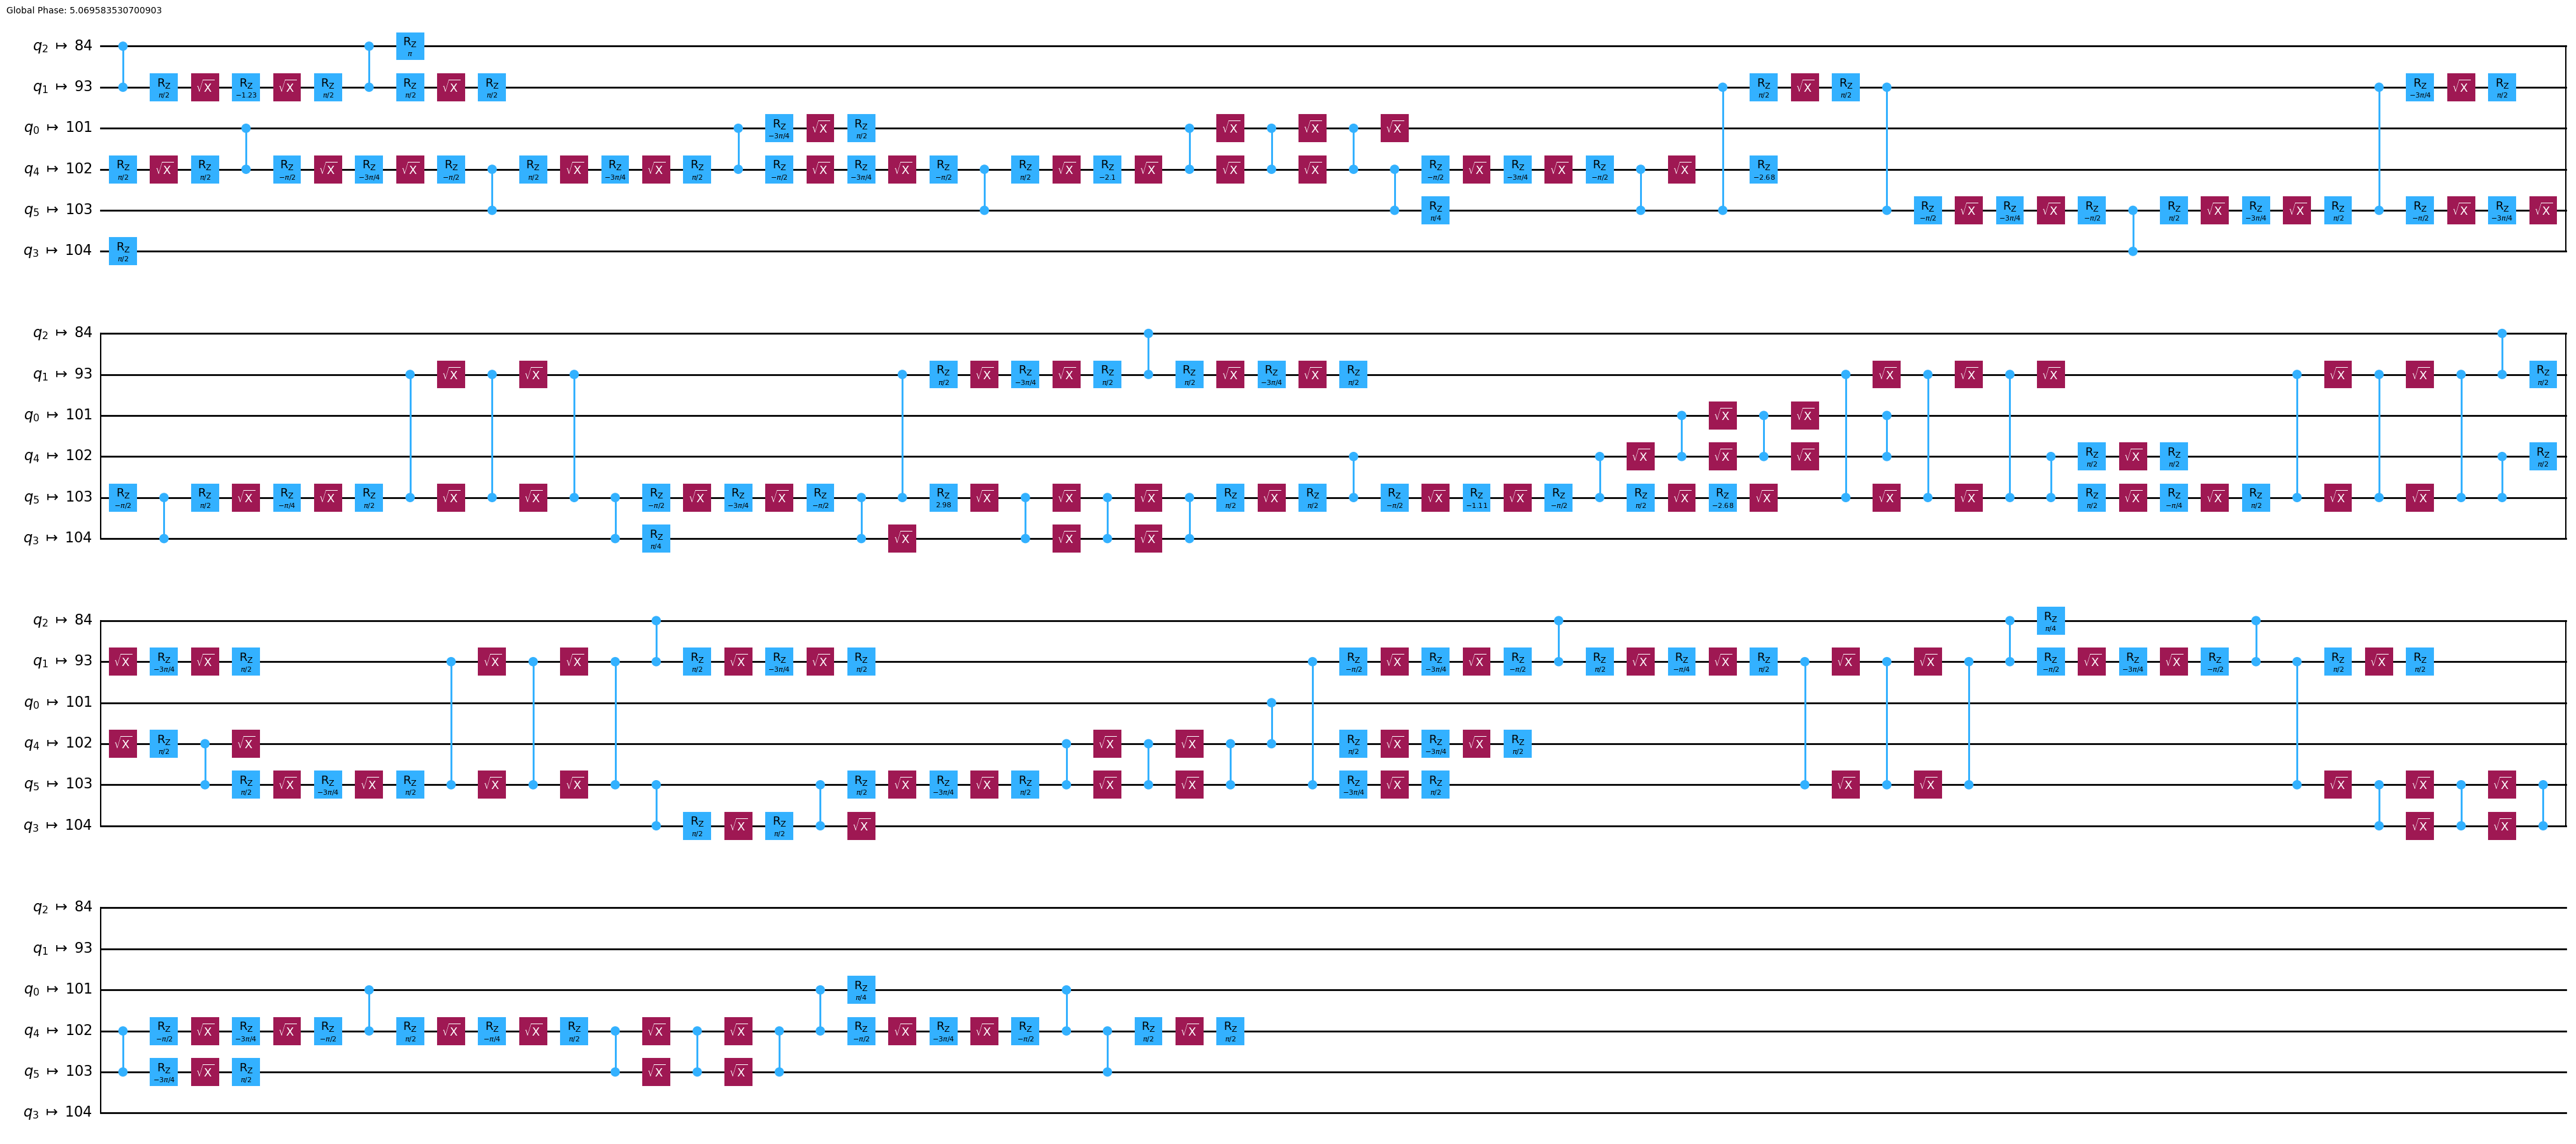

In [22]:
# Make a pass manager with our desired optimization level and backend
pm_lv1 = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)### your code here ###

# Run for our random circuit
tr_lv1 = pm_lv1.run(qc)

# uncomment the next line to draw circuit
tr_lv1.draw('mpl', idle_wires=False, fold=60)

이제 논리적 큐비트가 양자 하드웨어의 서로 다른 큐비트에 매핑된 것을 볼 수 있으며, 게이트 수가 더 적어진 것으 확인할 수 있을 것입니다. 지난번과 마찬가지로, transpiled circuit의 회로 깊이, 총 게이트 개수의 합, `scoring` 함수를 이용한 이 회로의 성능 점수를 알아내는 코드를 작성해주세요.

In [23]:
### Your code here ###

circuit_depths['opt_lv_1'] = tr_lv1.depth()
gate_counts['opt_lv_1'] = tr_lv1.size()
scores['opt_lv_1'] = scoring(tr_lv1, backend)


### Don't change code after this line ###

print("Optimization level 1 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_1'])
print("Gate count:", gate_counts['opt_lv_1'])
print("Score:", scores['opt_lv_1'])

Optimization level 1 results
Circuit depth: 205
Gate count: 303
Score: 933


### Optimization level = 2

최적화 레벨 2는 **중간 정도의 최적화**를 수행하며, 이는 다음을 의미합니다:

- 레이아웃/라우팅(Layout/Routing): 최적화 레벨 1에서 하는 것들 + 더 깊은 탐색과 최적화 함수의 시도 횟수로 휴리스틱하게 최적화 합니다. [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout)이 사용되지 않기 때문에, 실제 하드웨어의 큐비트 번호와 가상 큐비트 번호를 동일하게 유지하려는 시도를 하지 않습니다.
- [CommutativeCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.CommutativeCancellation#commutativecancellation)을 수행합니다.

이번에는 `optimization_level`을 2로 설정하고, FakeTorino 백엔드를 사용하여 `generate_preset_pass_manager`로 pass manager를 만들어 봅시다. `seed_transpiler` = `seed`로 설정해주세요.

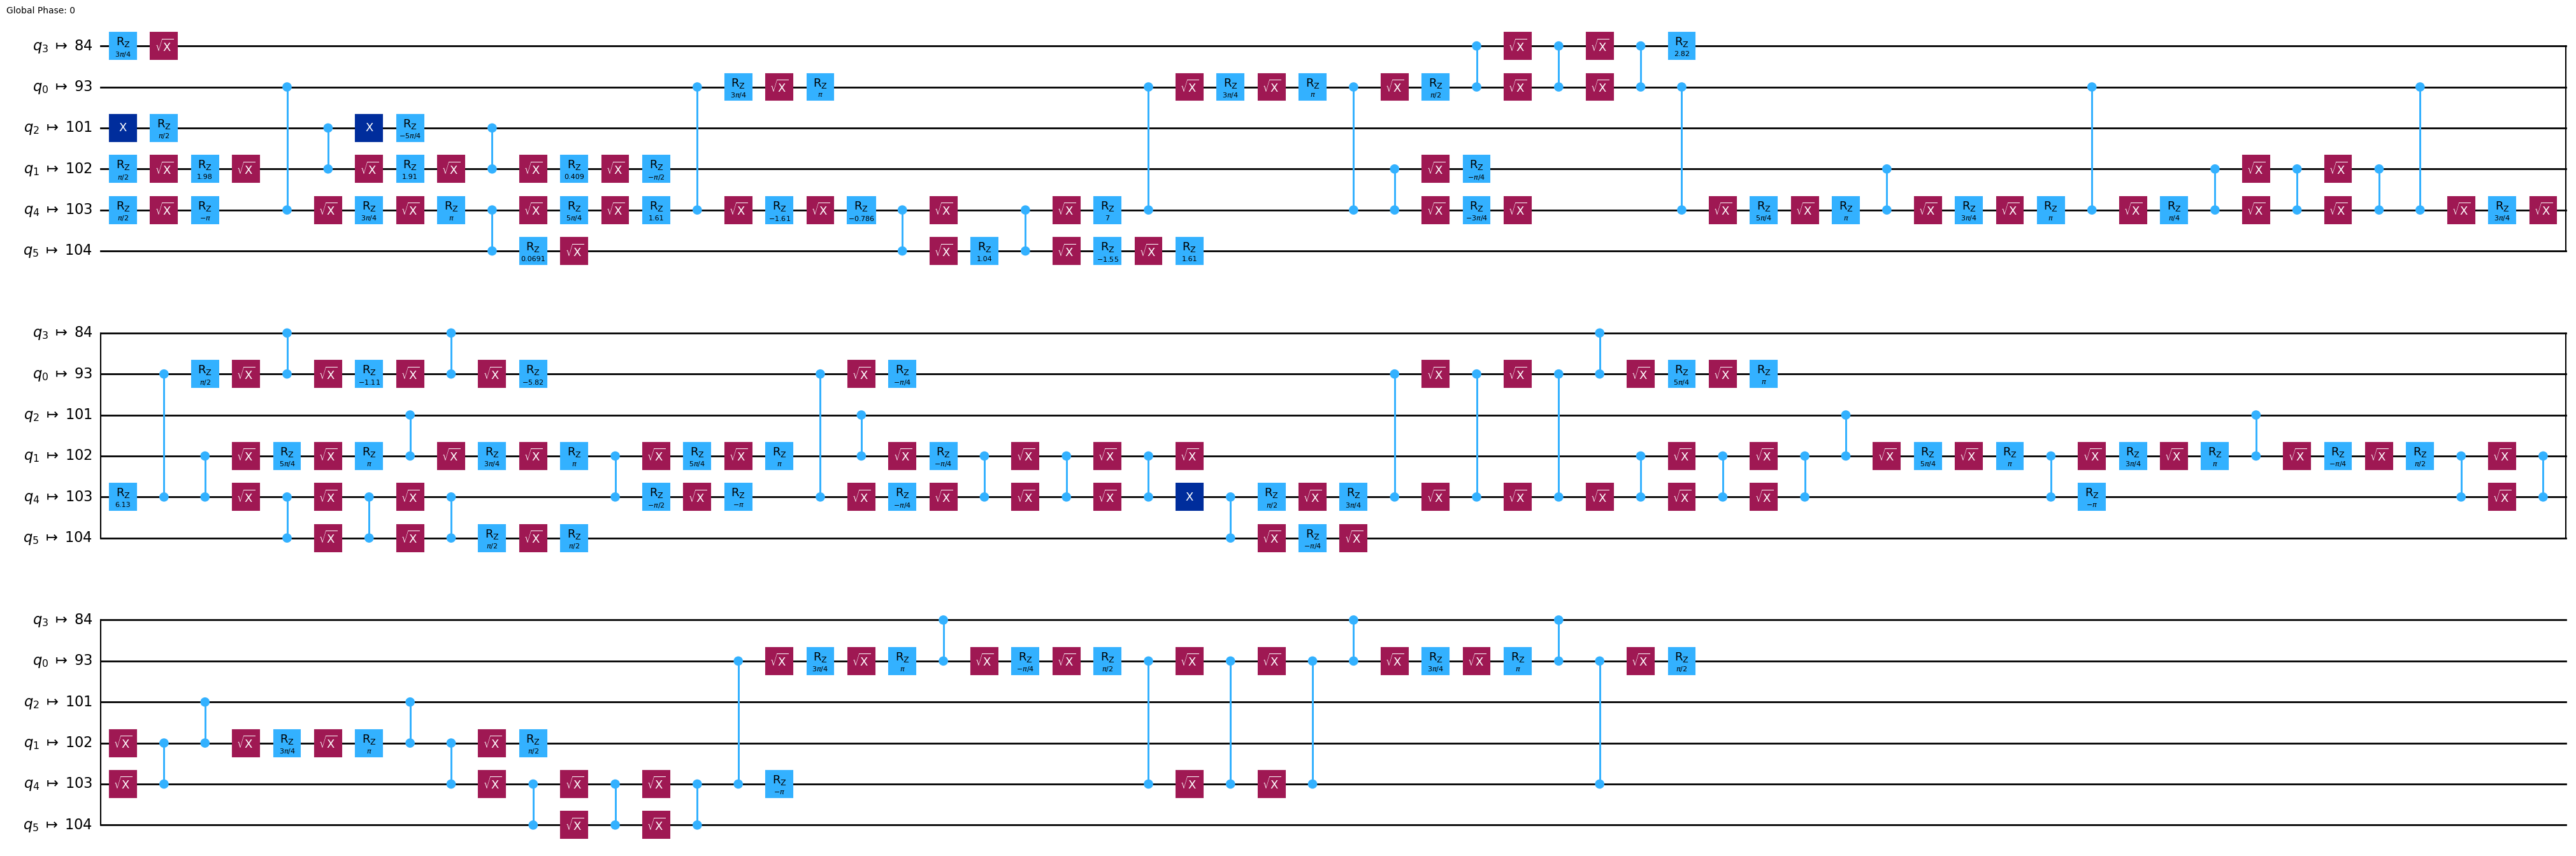

In [29]:
# Make a pass manager with our desired optimization level and backend
pm_lv2 = generate_preset_pass_manager(backend=backend, optimization_level=2, seed_transpiler=seed)### your code here ###

# Run for our random circuit
tr_lv2 = pm_lv2.run(qc)

# uncomment the next line to draw circuit
tr_lv2.draw('mpl', idle_wires=False, fold=60)

한 눈에 보아도 게이트 수가 상당히 줄어든 것을 알 수 있습니다. 논리 큐비트가 매핑된 실제 양자 하드웨어의 큐비트는 변하지 않았습니다. 이제 transpiling 성능을 측정해보겠습니다. 이전과 같은 코드입니다.

In [25]:
### Your code here ###

circuit_depths['opt_lv_2'] = tr_lv2.depth()
gate_counts['opt_lv_2'] = tr_lv2.size()
scores['opt_lv_2'] = scoring(tr_lv2, backend)

### Don't change code after this line ###

print("Optimization level 2 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_2'])
print("Gate count:", gate_counts['opt_lv_2'])
print("Score:", scores['opt_lv_2'])

Optimization level 2 results
Circuit depth: 157
Gate count: 251
Score: 806


### Optimization level = 3

최적화 레벨 3은 시간이 오래 걸리는 대신 **고급 최적화**를 수행합니다:

- 최적화 레벨 2에서 하는 것들 + 레이아웃/라우팅에 대한 추가적인 휴리스틱 최적화로 더 많은 노력/시험을 사용합니다.
- [Cartan's KAK Decomposition](https://arxiv.org/abs/quant-ph/0507171)를 사용하여 2-큐비트 블록의 재합성
- Unitarity-breaking 패스:
    - `OptimizeSwapBeforeMeasure`: SWAP 게이트를 가하는 것을 최대한 줄이기 위해 측정 명령을 내리는 고전 비트를 재타겟팅하여 측정 전의 SWAP gate를 제거합니다.
    - `RemoveDiagonalGatesBeforeMeasure`: 측정 전에 diagonal 게이트(예시: RZ, T, Z, 등)를 제거합니다. diagonal 2Q 게이트도 포함합니다.

이제 다음에 무엇을 해야할지 알고 계시죠!

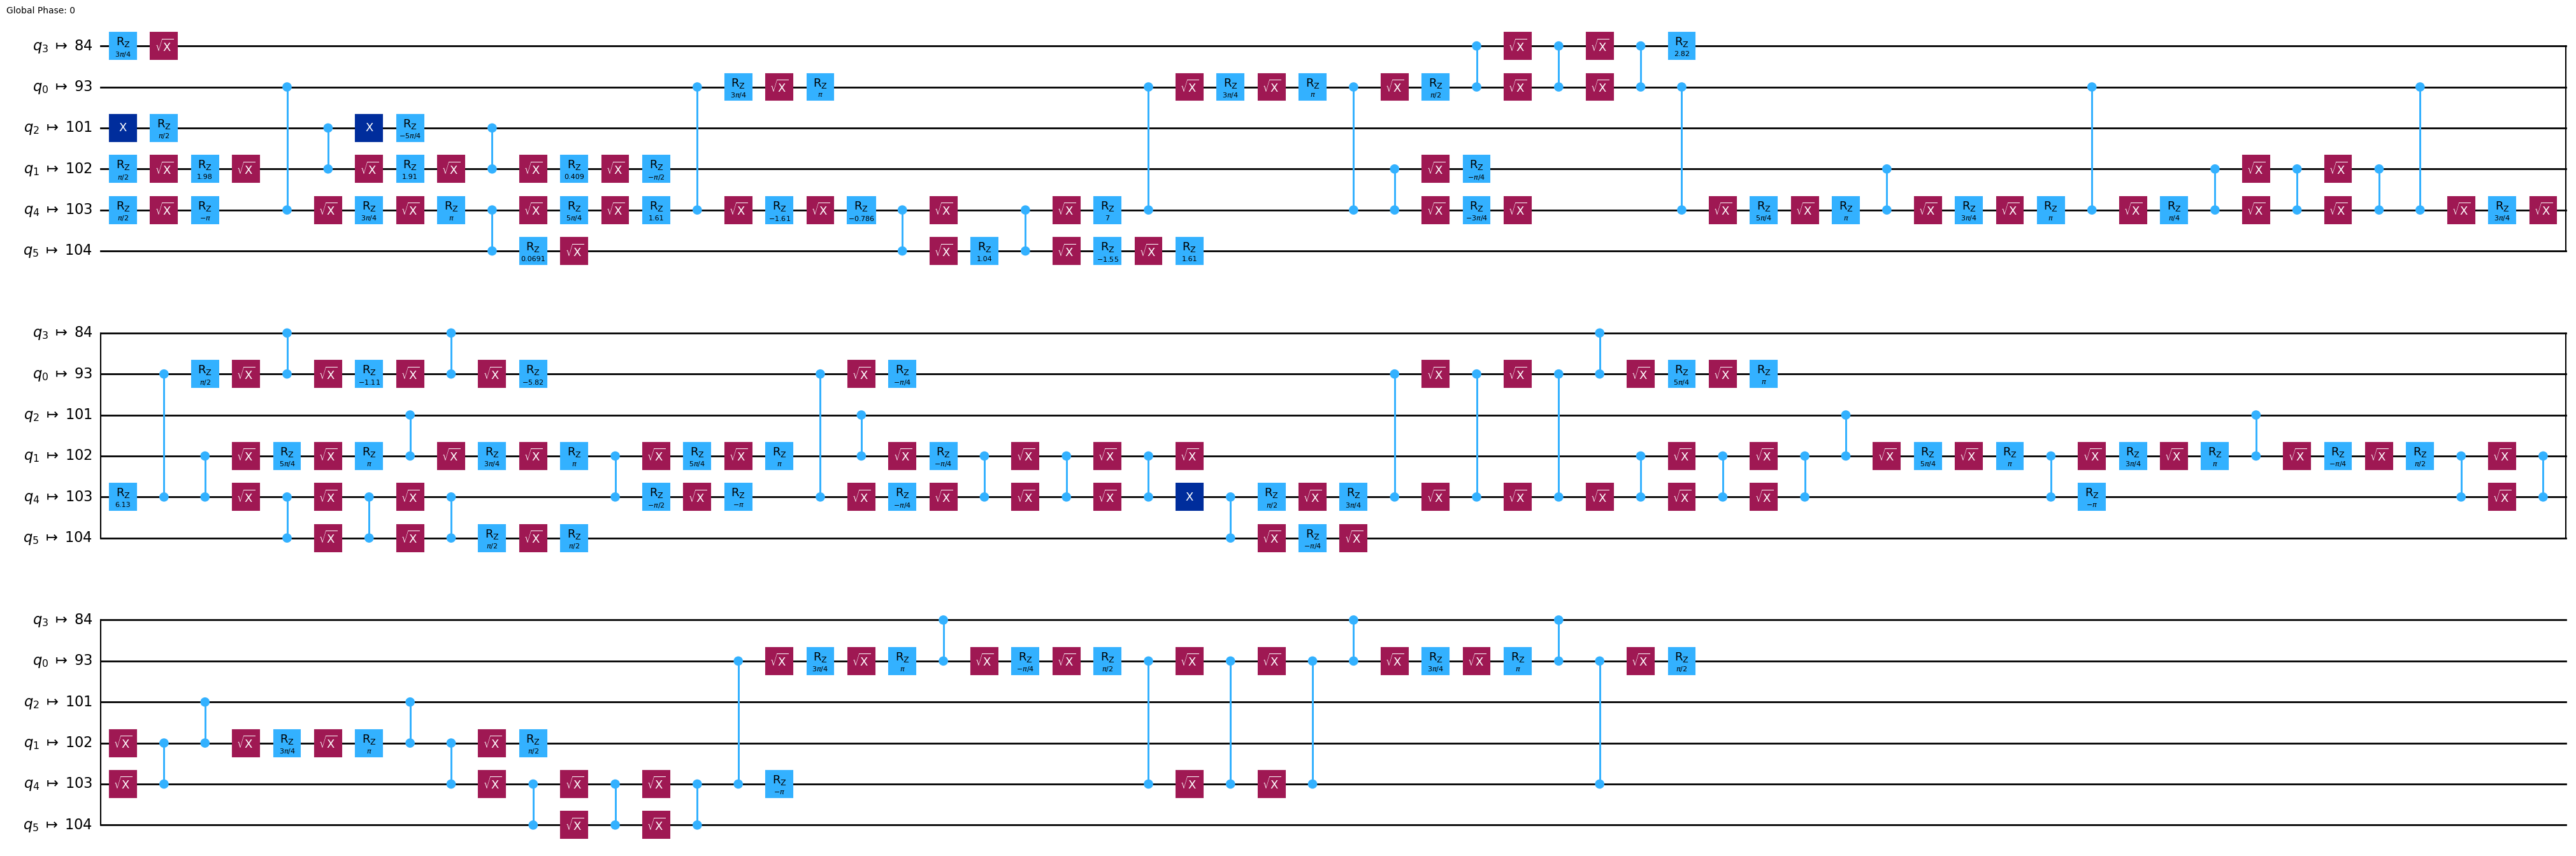

In [26]:
pm_lv3 = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed)   ### your code here ###

tr_lv3 = pm_lv3.run(qc)### your code here ###

# uncomment to draw circuit
tr_lv3.draw('mpl', idle_wires=False, fold=60)

놀랍지 않으신가요? 이제 게이트 수가 줄어들었습니다. 어떻게 작동했는지 살펴봅시다.

In [27]:
### Your code here ###

circuit_depths['opt_lv_3'] = tr_lv3.depth()
gate_counts['opt_lv_3'] = tr_lv3.size()
scores['opt_lv_3'] = scoring(tr_lv3, backend)

### Don't change code after this line ###

print("Optimization level 3 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_3'])
print("Gate count:", gate_counts['opt_lv_3'])
print("Score:", scores['opt_lv_3'])

Optimization level 3 results
Circuit depth: 157
Gate count: 251
Score: 806


이제 모든 결과가 준비도었으니, 각 최적화 수준에 다라 회로의 깊이, 게이트 수, 평가 점수가 어떻게 변화했는지 그래프로 나타내 보겠습니다.

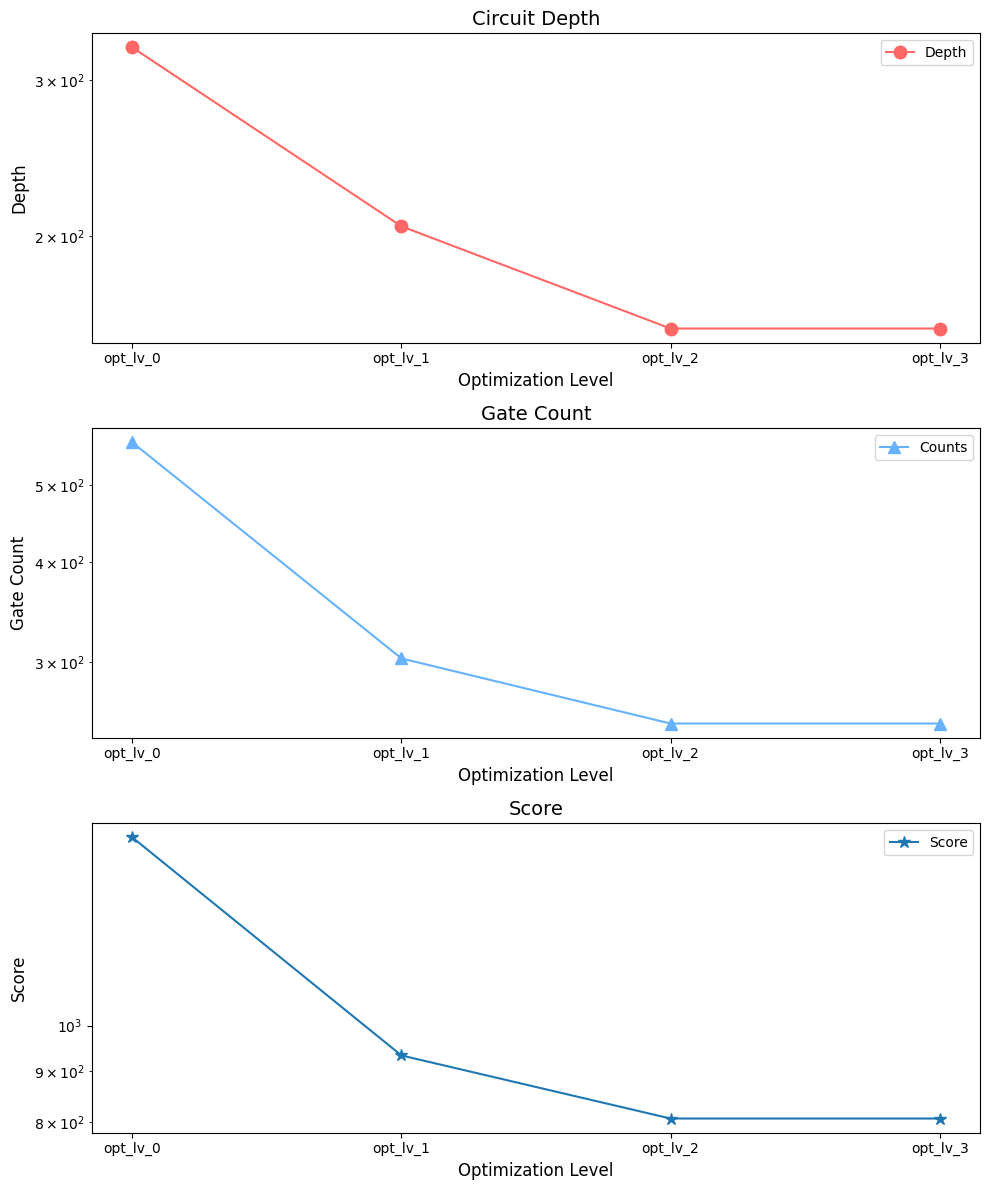

In [28]:
colors = ['#FF6666', '#66B2FF']
ax = ["opt_lv_0", "opt_lv_1", "opt_lv_2", "opt_lv_3"]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
ax1.semilogy(ax, [circuit_depths[key] for key in ax],'o-',markersize=9, color='#FF6666', label="Depth")
ax1.set_xlabel("Optimization Level", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
ax2.semilogy(ax, [gate_counts[key] for key in ax],'^-',markersize=9, color='#66B2FF', label="Counts")
ax2.set_xlabel("Optimization Level", fontsize=12)
ax2.set_ylabel("Gate Count", fontsize=12)
ax2.set_title("Gate Count", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
ax3.semilogy(ax, [scores[key] for key in ax],'*-',markersize=9, label="Score")
ax3.set_xlabel("Optimization Level", fontsize=12)
ax3.set_ylabel("Score", fontsize=12)
ax3.set_title("Score", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()

<div class="alert alert-block alert-success">

### Exercise 2: (Finish)

**해야할 일:** 이제 여러분의 작업을 정리할 시간입니다! 위에서 다양한 pass manager를 구성하고 테스트하며 각 pass manager에 대한 정보를 해당 배열에 저장하는 많은 작업을 하였습니다. 이 정보를 그래프로 나타내어 결과를 시각적으로 비교하기도 하였습니다. **손을 들어 위의 대회 스태프를 부르고 바로 위의 코드셀을 실행시킨 결과를 보여주고 확인을 받으세요.** 또한 아래의 코드 셀을 실행시켜 네 개의 pass manager를 모두 채점기에 제출하세요.

seed 값이 변경되지 않았는지 곡 확인하세요!

</div>


In [25]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge3b

answer2 = pm_lv0

grade_challenge3b(answer2, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


In [26]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge3c

answer3 = pm_lv1

grade_challenge3c(answer3, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


In [27]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge3d

answer4 = pm_lv2

grade_challenge3d(answer4, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


In [28]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge3e

answer5 = pm_lv3

grade_challenge3e(answer5, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


In [29]:
### Grader Cell - Submit your answer by running the following code
### You do not need to add any code into this cell

from qff_2024ku_grader.challenges.qff_ku2024 import grade_challenge3f

answer6 = [circuit_depths, gate_counts, scores]

grade_challenge3f(answer6, username)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


# Congratulations!

여러분은 transpile 의 6가지 단계에 대한 개념을 익히고, Qiskit에서 미리 구축해둔 4가지 수준(optimization level)의 transpilation을 구현해보았습니다. 사실 여러분의 양자 회로와 선택한 양자 하드웨어에 따라, Qiskit에서 미리 구축해둔 4가지 transpilation을 이용하는 것보다는 커스텀 pass manager를 구성하여 transpilation을 시키는 것이 더욱 좋은 결과를 얻는데 도움을 줍니다. 2024 Qiskit Fall Fest at Korea University에서는 커스텀 pass manager를 만드는 내용까지 다루지는 않겠습니다. 이에 대해 관심이 있으신 분은 [Transpiler Guide](https://docs.quantum.ibm.com/guides/transpile) 를 참고해주세요!

다른 챌린지 노트북도 파이팅입니다!